# Injector Optimization with NN Prior at LCLS
Aiming to optimize transverse beam size with solenoid SQ, CQ and 6 Quads

In [1]:
# optionally add scripts location to path
if True:
    import sys
    sys.path.append("../../")
    sys.path.append("../")

run_dir = "/home/physics3/ml_tuning/20230818_LCLS_optimize/"
print(sys.path)

['/home/physics3/rroussel/SLAC_Xopt/lcls/nn_prior', '/usr/local/lcls/tools/python/toolbox', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python39.zip', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/lib-dynload', '', '/home/physics3/.local/lib/python3.9/site-packages', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages', '../../', '../']


## Set up image diagnostic

In [2]:
from scripts.image import ImageDiagnostic
import yaml

fname = "../OTR3_config.yml"
image_diagnostic = ImageDiagnostic.parse_obj(yaml.safe_load(open(fname)))
image_diagnostic.save_image_location = run_dir
image_diagnostic.n_fitting_restarts = 2
image_diagnostic.visualize = False
image_diagnostic.background_file = run_dir + "OTRS_IN20_621_background.npy"
print(image_diagnostic.yaml())

{screen_name: 'OTRS:IN20:621', array_data_suffix: IMAGE, array_n_cols_suffix: ROI_XNP,
  array_n_rows_suffix: ROI_YNP, resolution_suffix: RESOLUTION, beam_shutter_pv: 'IOC:BSY0:MP01:MSHUTCTL',
  background_file: /home/physics3/ml_tuning/20230818_LCLS_optimize/OTRS_IN20_621_background.npy,
  save_image_location: /home/physics3/ml_tuning/20230818_LCLS_optimize/, roi: null,
  min_log_intensity: 4.0, bounding_box_half_width: 3.0, wait_time: 0.1, n_fitting_restarts: 2,
  visualize: false, testing: false}



In [3]:
#image_diagnostic.measure_background(file_location=run_dir)

In [4]:
image_diagnostic.background_file

'/home/physics3/ml_tuning/20230818_LCLS_optimize/OTRS_IN20_621_background.npy'

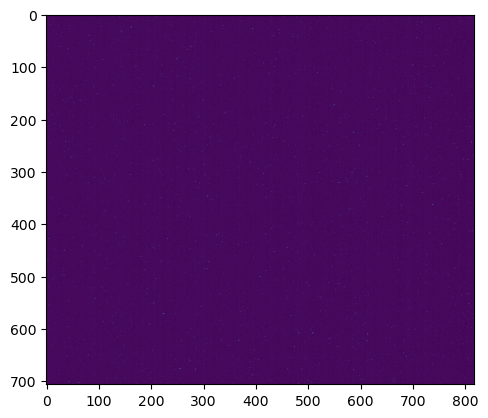

In [5]:
import matplotlib.pyplot as plt
plt.imshow(image_diagnostic.background_image)

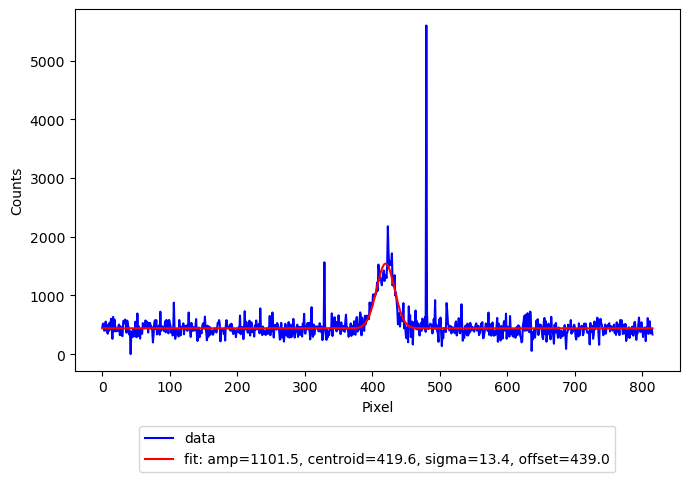

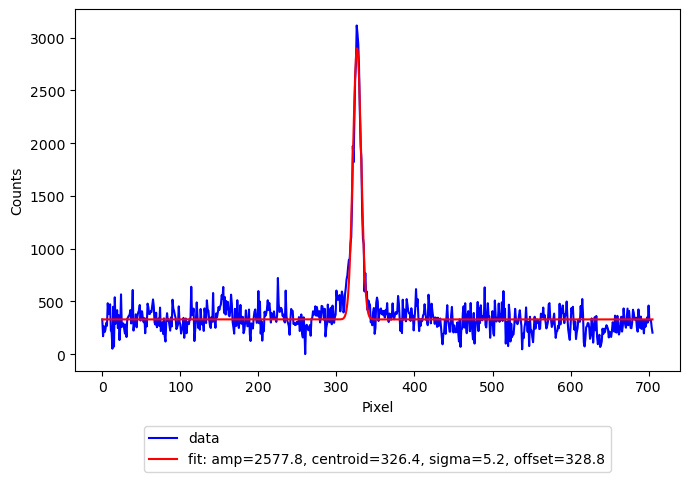

{'Cx': 419.5913970808733,
 'Cy': 326.4370499112423,
 'Sx': 162.02904166869217,
 'Sy': 63.31253007448463,
 'bb_penalty': -208.64315294649782,
 'total_intensity': 1123192.5999999996,
 'log10_total_intensity': 6.050454233505679}

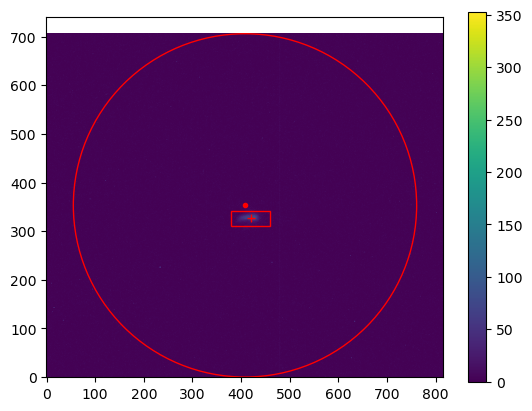

In [6]:
image_diagnostic.test_measurement()

In [7]:
import pandas as pd
filename = "../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')

In [8]:
IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
            "log10_total_intensity": ["GREATER_THAN", image_diagnostic.min_log_intensity]
        }

from xopt import VOCS
VARIABLES = ["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL","QUAD:IN20:122:BCTRL",'QUAD:IN20:361:BCTRL','QUAD:IN20:371:BCTRL','QUAD:IN20:425:BCTRL','QUAD:IN20:441:BCTRL','QUAD:IN20:511:BCTRL','QUAD:IN20:525:BCTRL']
vocs = VOCS(
        variables = {ele: VARIABLE_RANGES[ele] for ele in VARIABLES},
        constraints = IMAGE_CONSTRAINTS,
        objectives = {"total_size": "MINIMIZE"},
    )
print(vocs)

variables={'SOLN:IN20:121:BCTRL': [0.377, 0.498], 'QUAD:IN20:121:BCTRL': [-0.021, 0.021], 'QUAD:IN20:122:BCTRL': [-0.021, 0.021], 'QUAD:IN20:361:BCTRL': [-4.32, -1.08], 'QUAD:IN20:371:BCTRL': [1.09, 4.31], 'QUAD:IN20:425:BCTRL': [-7.56, -1.08], 'QUAD:IN20:441:BCTRL': [-1.08, 7.56], 'QUAD:IN20:511:BCTRL': [-1.08, 7.56], 'QUAD:IN20:525:BCTRL': [-7.56, -1.08]} constraints={'bb_penalty': ['LESS_THAN', 0.0], 'log10_total_intensity': ['GREATER_THAN', 4.0]} objectives={'total_size': 'MINIMIZE'} constants={} observables=[]


In [9]:
from epics import caput, caget_many
from time import sleep
import numpy as np
def eval_beamsize(inputs):
        global image_diagnostic
        # set PVs
        for k, v in inputs.items():
            print(f'CAPUT {k} {v}')
            caput(k, v)

        sleep(2.0)

        # get beam sizes from image diagnostic
        metadata = inputs
        results = image_diagnostic.measure_beamsize(5, **metadata)
        results["S_x_mm"] = np.array(results["Sx"]) * 1e-3
        results["S_y_mm"] = np.array(results["Sy"]) * 1e-3

        # get other PV's NOTE: Measurements not synchronous with beamsize measurements!
        results = results

        # add total beam size
        results["total_size"] = np.sqrt(np.array(results["Sx"]) ** 2 + np.array(results["Sy"]) ** 2)
        # results["total_size"] = np.sqrt(np.abs(np.array(results["Sx"])) * np.array(results["Sy"]))
        return results

## Define NN prior

In [10]:
import torch

from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

In [11]:
model_path = "lcls_cu_injector_nn_model/"

# # load nn_to_cal transformers
# reg = "low"  # "low" or "high"
# input_nn_to_cal = torch.load(f"calibration/input_nn_to_cal_{reg}_reg.pt")
# output_nn_to_cal = torch.load(f"calibration/output_nn_to_cal_{reg}_reg.pt")

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_path + "model/pv_variables.yml"))
# input_variables, output_variables = variables_from_yaml(open(f"calibration/pv_variables_{reg}_reg.yml"))

# replace keys in input variables
input_variables = {name.replace("BACT", "BCTRL"): ele for name, ele in input_variables.items()}

# create LUME-model
lume_model = PyTorchModel(
    model_file=model_path + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
    # input_transformers=[input_pv_to_sim, input_sim_to_nn, input_nn_to_cal],
    # output_transformers=[output_nn_to_cal, output_sim_to_nn, output_pv_to_sim],
)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=vocs.variable_names,
    output_order=lume_model.outputs[0:2],
)

# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

print(lume_module.feature_order)
print(lume_module.output_order)

['QUAD:IN20:121:BCTRL', 'QUAD:IN20:122:BCTRL', 'QUAD:IN20:361:BCTRL', 'QUAD:IN20:371:BCTRL', 'QUAD:IN20:425:BCTRL', 'QUAD:IN20:441:BCTRL', 'QUAD:IN20:511:BCTRL', 'QUAD:IN20:525:BCTRL', 'SOLN:IN20:121:BCTRL']
['OTRS:IN20:571:XRMS', 'OTRS:IN20:571:YRMS']


## Run Xopt

In [12]:
from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

# remember to set use low noise prior to false!!!
model_constructor = StandardModelConstructor(
    use_low_noise_prior=False,
    mean_modules={"total_size": objective_model},
)
generator = UpperConfidenceBoundGenerator(
    vocs=vocs,
    model_constructor=model_constructor,
    # turbo_controller="optimize"
)
generator.numerical_optimizer.max_iter = 200
evaluator = Evaluator(function=eval_beamsize)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.options.dump_file = run_dir + "nn_optimization.yml"
X


            Xopt
________________________________
Version: 2.0a1+74.g9067c79
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: true, dump_file: /home/physics3/ml_tuning/20230818_LCLS_optimize/nn_optimization.yml,
  max_evaluations: null}
generator:
  name: upper_confidence_bound
  model: null
  turbo_controller: null
  use_cuda: false
  model_constructor:
    name: standard
    use_low_noise_prior: false
    covar_modules: {}
    mean_modules: {total_size: mean_modules_total_size.pt}
    trainable_mean_keys: []
  numerical_optimizer: {name: LBFGS, n_raw_samples: 20, n_restarts: 20, max_iter: 200}
  max_travel_distances: null
  fixed_features: null
  computation_time: {}
  n_candidates: 1
  n_monte_carlo_samples: 128
  beta: 2.0
evaluator:
  function: __main__.eval_beamsize
  max_workers: 1
  function_kwargs: {}
  vectorized: false
vocs:
  variables:
    SOLN:IN20:121:BCTRL: [0.377, 0.498]
    QUAD:IN20:121:BCTRL: [-0.021, 0.021]
    QUAD:IN20:122:BCTRL: [-0.021, 0.021]
    QU

In [13]:
import pandas as pd

default = {'SOLN:IN20:121:BCTRL': 0.474877290758955,
 'QUAD:IN20:121:BCTRL': -0.0048398437,
 'QUAD:IN20:122:BCTRL': 0.0018,
 'QUAD:IN20:361:BCTRL': -3.16,
 'QUAD:IN20:371:BCTRL': 2.5352702,
 'QUAD:IN20:425:BCTRL': -1.1,
 'QUAD:IN20:441:BCTRL': -0.8118599,
 'QUAD:IN20:511:BCTRL': 3.6494056,
 'QUAD:IN20:525:BCTRL': -3.2522187,
}

X.evaluate_data(pd.DataFrame(default, index=[0]))

CAPUT SOLN:IN20:121:BCTRL 0.474877290758955
CAPUT QUAD:IN20:121:BCTRL -0.0048398437
CAPUT QUAD:IN20:122:BCTRL 0.0018
CAPUT QUAD:IN20:361:BCTRL -3.16
CAPUT QUAD:IN20:371:BCTRL 2.5352702
CAPUT QUAD:IN20:425:BCTRL -1.1
CAPUT QUAD:IN20:441:BCTRL -0.8118599
CAPUT QUAD:IN20:511:BCTRL 3.6494056
CAPUT QUAD:IN20:525:BCTRL -3.2522187


,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,Cx,...,Sy,bb_penalty,total_intensity,log10_total_intensity,save_filename,S_x_mm,S_y_mm,total_size,xopt_runtime,xopt_error
1,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,418.864064,...,97.573391,-215.014566,1132892.0,6.054189,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.091954,0.097573,134.07513,6.506689,False
1,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,418.864107,...,97.581942,-215.041696,1132892.0,6.054189,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.091772,0.097582,133.95617,6.506689,False
1,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,418.381988,...,118.28032,-211.703073,1102857.0,6.042519,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.088159,0.11828,147.520414,6.506689,False
1,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,418.797861,...,24.24,-243.786268,1123084.2,6.050412,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.089327,0.02424,92.557478,6.506689,False
1,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,419.232538,...,105.026849,-212.652662,1107164.2,6.044212,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.096054,0.105027,142.327018,6.506689,False


In [14]:
X.data

,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,Cx,...,Sy,bb_penalty,total_intensity,log10_total_intensity,save_filename,S_x_mm,S_y_mm,total_size,xopt_runtime,xopt_error
1,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,418.864064,...,97.573391,-215.014566,1132892.0,6.054189,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.091954,0.097573,134.07513,6.506689,False
2,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,418.864107,...,97.581942,-215.041696,1132892.0,6.054189,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.091772,0.097582,133.95617,6.506689,False
3,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,418.381988,...,118.28032,-211.703073,1102857.0,6.042519,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.088159,0.11828,147.520414,6.506689,False
4,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,418.797861,...,24.24,-243.786268,1123084.2,6.050412,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.089327,0.02424,92.557478,6.506689,False
5,0.474877,-0.00484,0.0018,-3.16,2.53527,-1.1,-0.81186,3.649406,-3.252219,419.232538,...,105.026849,-212.652662,1107164.2,6.044212,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.096054,0.105027,142.327018,6.506689,False


In [ ]:
for i in range(10):
    print(i)
    X.step()

0
CAPUT QUAD:IN20:121:BCTRL -0.0006569459438323967
CAPUT QUAD:IN20:122:BCTRL -0.013476496070623399
CAPUT QUAD:IN20:361:BCTRL -1.9412617135047916
CAPUT QUAD:IN20:371:BCTRL 1.4502305349707605
CAPUT QUAD:IN20:425:BCTRL -5.056526312828064
CAPUT QUAD:IN20:441:BCTRL 6.322571411132813
CAPUT QUAD:IN20:511:BCTRL 4.366261024475098
CAPUT QUAD:IN20:525:BCTRL -4.079642100334167
CAPUT SOLN:IN20:121:BCTRL 0.3978289655148983
1
CAPUT QUAD:IN20:121:BCTRL 0.00168666028417647
CAPUT QUAD:IN20:122:BCTRL -0.0197070614118129
CAPUT QUAD:IN20:361:BCTRL -2.1918693825602533
CAPUT QUAD:IN20:371:BCTRL 2.5305332718789577
CAPUT QUAD:IN20:425:BCTRL -2.193413701280951
CAPUT QUAD:IN20:441:BCTRL 2.9709345915913588
CAPUT QUAD:IN20:511:BCTRL 1.76187667965889
CAPUT QUAD:IN20:525:BCTRL -1.3648008571565153
CAPUT SOLN:IN20:121:BCTRL 0.47443872234318407
2
CAPUT QUAD:IN20:121:BCTRL -0.0012324057711256137
CAPUT QUAD:IN20:122:BCTRL -0.010364558265822079
CAPUT QUAD:IN20:361:BCTRL -2.380706508152025
CAPUT QUAD:IN20:371:BCTRL 3.00989

<Axes: >

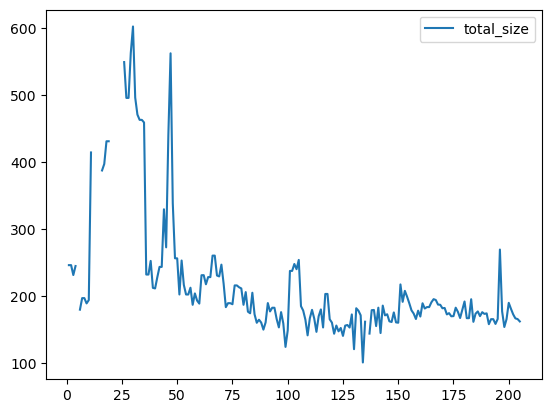

In [21]:
X.data.plot(y="total_size")

<Axes: >

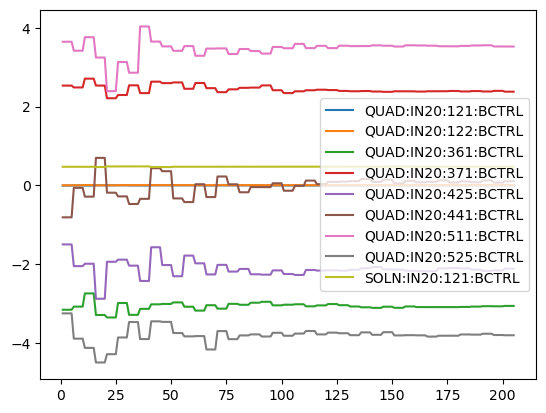

In [22]:
X.data.plot(y=X.vocs.variable_names)

In [27]:
X.data.head()["total_size"].mean()

242.62081217603858

In [28]:
X.data.tail()["total_size"].mean()

170.1646417339693

In [29]:
X.data["total_size"].min()

101.43224982729883

In [37]:
from scripts.utils.read_files import read_file
res = read_file(X.data.iloc[10]["save_filename"])

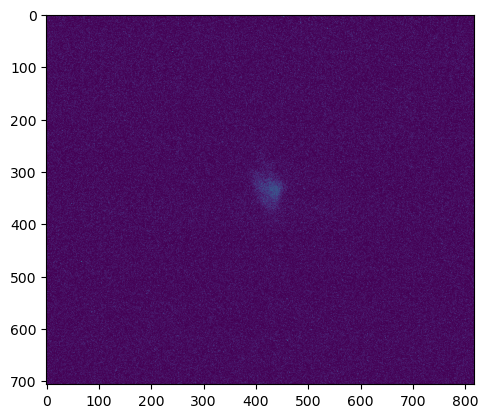

In [39]:
plt.imshow(res["images"][0])

In [40]:
res

{'images': array([[[ 0. ,  5.8,  0. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  5.2,  0.8, ...,  1.6,  0. ,  1. ],
         [ 0. ,  0. ,  0. , ...,  3.8,  2.6,  1.4],
         ...,
         [ 0. ,  0. ,  1.8, ...,  2. ,  0. ,  5.4],
         [ 0. ,  3.4,  0. , ...,  0. ,  0.4,  0.2],
         [ 0. ,  0. ,  0.4, ...,  1.6,  0. ,  1.8]],
 
        [[ 0. ,  0. ,  2. , ...,  0. ,  0. ,  2.4],
         [ 0. ,  1.2,  0. , ...,  0. ,  0. ,  0. ],
         [ 2.2,  0. ,  5.4, ...,  3.8,  0. ,  3.4],
         ...,
         [ 1.8,  0.8,  5.8, ...,  1. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0.4,  5.4,  0. ],
         [ 0. ,  5.6,  0. , ...,  0. ,  0. ,  2.8]],
 
        [[ 0. ,  0. ,  2. , ...,  0. ,  0. ,  2.4],
         [ 0. ,  1.2,  0. , ...,  0. ,  0. ,  0. ],
         [ 2.2,  0. ,  5.4, ...,  3.8,  0. ,  3.4],
         ...,
         [ 1.8,  0.8,  5.8, ...,  1. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0.4,  5.4,  0. ],
         [ 0. ,  5.6,  0. , ...,  0. ,  0. ,  2.8]],
 
   